In [31]:
import cv2 
import numpy as np
import os
from pdf2image import convert_from_path
import pytesseract
import PIL
from PIL import Image
import pandas as pd
import time
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

In [32]:
croppedImagePath = "D:\\Anaconda3\\Scripts\Shitiz\\SignatureObjectDetection\\croppedImages\\" 

In [33]:
#Dimentions of the signature box which is expected to haver a 

def SaveCroppedSigImages(imagePath):
    
    signatureAboveRows = None
    signatureImage = Image.open(filePath)
    fileInfo = pytesseract.image_to_data(signatureImage,lang='eng', output_type='data.frame')
    fileInfo = fileInfo.replace(np.nan, '', regex=True)
    
    # Format1 Check
    savedCroppedImages = SaveIfFormat1Type(fileInfo, signatureImage)
    return savedCroppedImages

In [34]:
def PreprocessedImageList(imagePath):
    # Load an color image in grayscale
    img = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    #cv2.imshow('MedianImage', img)
    kernel = np.ones((3,3), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=1)
    return img_erosion

In [35]:
#Check Format1 - DocuSigned
def SaveIfFormat1Type(fileInfo, signatureImage):
    docuSigByBoxL = 500
    docuSigByBoxB = 90
    signBoxB = 0 
    signBoxL = 0
    
    signatureRows = fileInfo[fileInfo['text'] == 'DocuSigned']
    if not len(signatureRows) > 0:
        return False
    else:
        for index in range(len(signatureRows)):
            if ((signatureRows.iloc[index])['text'] == 'DocuSigned'):
                signBoxB = docuSigByBoxB
                signBoxL = docuSigByBoxL
                x1,y1,x2,y2 = ((signatureRows.iloc[index])['left'] - 50, 
                                (signatureRows.iloc[index])['top'] + (signatureRows.iloc[index])['height'] - 2, 
                                (signatureRows.iloc[index])['left'] + docuSigByBoxL,  
                                (signatureRows.iloc[index])['top'] + (signatureRows.iloc[index])['height'] + docuSigByBoxB)
                croppedImage = signatureImage.crop((x1,y1,x2,y2))
                croppedImage.show()
                fileName = croppedImagePath + str(index) +".jpg"
                croppedImage.save(fileName)
        return True

In [36]:
def IsDocSigned():
    
    isSigned = False
    imageFilesList = []
    signatureBoundrySigned = []
    
    for r, d, f in os.walk(croppedImagePath):
        for file in f:
            if '.jpg' in file:
                imageFilesList.append(os.path.join(r, file))
            
    for filePath in imageFilesList:
        img_median = PreprocessedImageList(filePath)

        #Step2 - SEGMENTATION
        
        #Connected Component Labelling, Rectangle fitting & area-based filtering
        ret1, thresh = cv2.threshold(img_median, 127, 255, 0)
        ret, connectedLabels = cv2.connectedComponents(thresh,connectivity = 4)
        
        # find contours
        contours, hierarchy = cv2.findContours(connectedLabels, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros(thresh.shape, np.uint8)
        
        counter = 0
        # filter contours
        for idx in range(0, len(hierarchy[0])):
            rect = x, y, rect_width, rect_height = cv2.boundingRect(contours[idx])
            
            # fill the contour
            mask = cv2.drawContours(mask, contours, idx, (150, 255, 255), cv2.FILLED)
            
            # ratio of non-zero pixels in the filled region
            r = float(cv2.countNonZero(mask)) / (rect_width * rect_height)
            if r > 0.45 and rect_height > 25 and rect_width > 25:
                rgb = cv2.rectangle(thresh , (x, y+rect_height), (x+rect_width, y), (0,255,0),1)
                counter = counter + 1
                isSigned = True
        if counter > 1:
            signatureBoundrySigned.append('Signed')
            segmented_Image = Image.fromarray(rgb)
            #segmented_Image.show()
            plt.figure()
            plt.imshow(segmented_Image)
        else:
            signatureBoundrySigned.append('Not Signed')
    
    for r, d, f in os.walk(croppedImagePath):
        for file in f:
            if '.jpg' in file:
                os.remove(os.path.join(r, file))
    return signatureBoundrySigned

Signed-Signed


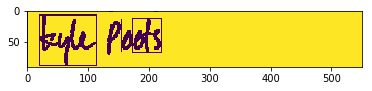

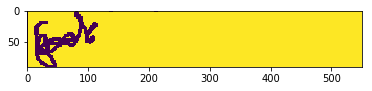

In [38]:
filePath = r'D:\Shitiz\Sig Formats\Done\DocuSignedBy\2018-11-07_SOW_BADabstract.pdf.jpg'
if (SaveCroppedSigImages(filePath)):
    a = IsDocSigned()
    print('-'.join(a) )
else:
    print('Not Signed')